In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import mediapipe as mp
from scipy import signal

#Show plots inline 
%matplotlib inline


In [2]:
#video configuration
video_path = r"C:\Users\Ghufran\Desktop\W0101\2024W0101P001.MOV"

In [3]:
#Choose whether to show debug images
SHOW_DEBUG_IMAGES = True

In [4]:
#Mediapipe face Mesh setup 
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

In [5]:
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise RuntimeError(f"Cannot open video:{video_path }")

fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration_sec = frame_count / fps if fps>0 else None

print(f"Video_path: {video_path}")
print(f"Resolutions : {width} x {height}")
print(f"FPS : {fps}")
print(f"Total frames : {frame_count}")
print(f"Duration (sec) : {duration_sec:.2f}")

Video_path: C:\Users\Ghufran\Desktop\W0101\2024W0101P001.MOV
Resolutions : 1920 x 1080
FPS : 59.94005994005994
Total frames : 11100
Duration (sec) : 185.19


In [6]:
#Read amiddle frame for visualization
mid_frame_idx = frame_count//2
cap.set(cv2.CAP_PROP_POS_FRAMES, mid_frame_idx)
ret, frame_bgr = cap.read()

if not ret:
    raise RuntimeError(f"Cannot read frame at index {mid_frame_id} from video:{video_path }") 
      

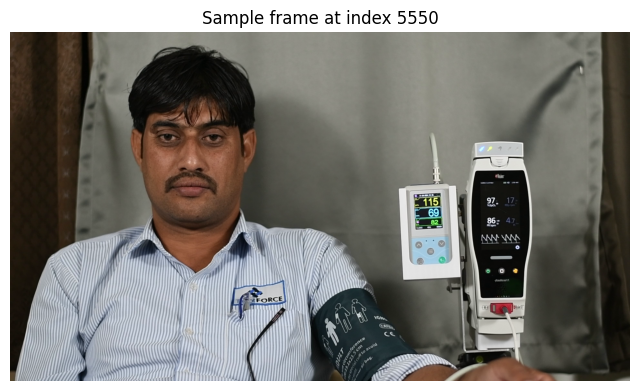

In [7]:
#convert BGR (opncv default) to RGB for plotting
frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (8,6))
plt.imshow(frame_rgb)
plt.title(f"Sample frame at index {mid_frame_idx}")
plt.axis("off")
plt.show()

In [8]:
#Reset video tothe begining for later processing
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

True

In [9]:
# ==== Run FceMesh on the sample frame and visualize landmarks ===

image_rgb = frame_rgb.copy()  # from previous cell
h, w, _ = image_rgb.shape

In [10]:
# Mediapipe expects RGB image

results = face_mesh.process(image_rgb)

if not results.multi_face_landmarks:
    raise RuntimeError("No face landmarks detected in the sample frame")

face_landmarks = results.multi_face_landmarks[0]

c:\Users\Ghufran\anaconda3\envs\roi_env\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [11]:
#Draw a subset of landmark(e.g., every 10th point) for visualization
landmark_points = []
for idx, lm in enumerate(face_landmarks.landmark):
    x = int(lm.x * w)
    y = int(lm.y * h)
    landmark_points.append((x,y))

In [12]:
# Visualize landmarks
debug_image = image_rgb.copy()
for i, (x,y) in enumerate(landmark_points):
    if i % 10 == 0:  # Draw every 10th landmark
        cv2.circle(debug_image, (x,y), 1, (0,255,0), -1)

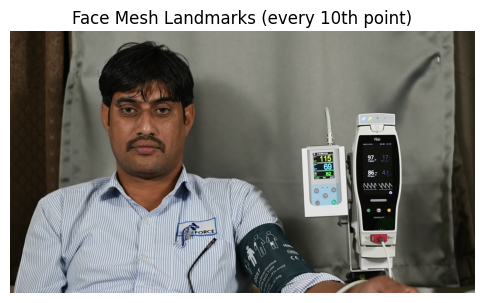

In [13]:
plt.figure(figsize=(6,8))
plt.imshow(debug_image)
plt.title("Face Mesh Landmarks (every 10th point)")
plt.axis("off")     
plt.show()

In [14]:
# === Define ROIs using landmark indices and visualize them ===

#approximately landmark indices for ROIs (you can fine-tune)
ROI_LANDMARKS = {
    "forehead": [10,338,297,332,284,251],
    "left_cheek": [234,93,132,58,172,136],
    "right_cheek":[454,323,361,288,397,365,]
}

In [15]:
def get_roi_bbox(landmarks, indices, img_shape):
    h,w,_ = img_shape
    xs, ys = [], []
    for idx in indices:
        lm = landmarks[idx]
        xs.append(int(lm.x * w))
        ys.append(int(lm.y * h))
    x_min, x_max = max(min(xs), 0), min(max(xs), w-1)
    y_min, y_max = max(min(ys), 0), min(max(ys), h-1)
    return x_min, y_min, x_max, y_max

In [16]:
#Visualize ROIs on the sample frame
roi_image = image_rgb.copy()
colors = {
    "forehead": (255,0,0),
    "left_cheek": (0,255,0),
    "right_cheek": (0,0,255)
}

In [17]:
for name, idxs in ROI_LANDMARKS.items():
    x1, y1, x2, y2 = get_roi_bbox(face_landmarks.landmark, idxs, image_rgb.shape)
    cv2.rectangle(roi_image, (x1, y1), (x2, y2), colors[name], 2)
    cv2.putText(roi_image, name, (x1, max(y1 - 5, 0)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[name], 1, cv2.LINE_AA)

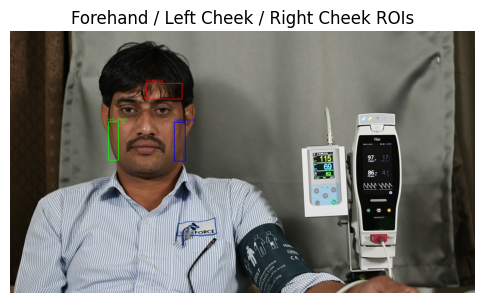

In [18]:
plt.figure(figsize=(6,8))
plt.imshow(roi_image)
plt.title("Forehand / Left Cheek / Right Cheek ROIs")
plt.axis("off")
plt.show()

In [19]:
# ===Loop over video and extract mean green intensity per ROI ===
# Rewind to start

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

roi_signal = {
    "forehead": [],
    "left_cheek": [],
    "right_cheek": []
}   

frame_indices = []

frame_idx = 0

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break
    
    frame_idx += 1
    frame_indices.append(frame_idx)

    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    h,w,_ = frame_rgb.shape

    #Run FaceMesh
    results = face_mesh.process(frame_rgb)

    if not results.multi_face_landmarks:
        #No face detected, append NaN
        for key in roi_signal.keys():
            roi_signal[key].append(np.nan)
        continue

    landmarks = results.multi_face_landmarks[0].landmark

    for name, idxs in ROI_LANDMARKS.items():
        x1, y1, x2, y2 = get_roi_bbox(landmarks, idxs, frame_rgb.shape)
        roi = frame_rgb[y1:y2, x1:x2]
        mean_green = np.mean(roi[:,:,1])  # Green channel
        roi_signal[name].append(mean_green)

In [22]:
# Convert lists to numpy arrays
for name in roi_signal:
    roi_signal[name] = np.array(roi_signal[name], dtype=np.float32)

frame_indices = np.array(frame_indices)

print(f"Total frames processed: {len(frame_indices)}")
for name, sig in roi_signal.items():
    print(f"{name}: signal length = {len(sig)}, NaNs = {np.isnan(sig).sum()}")

Total frames processed: 11100
forehead: signal length = 11100, NaNs = 0
left_cheek: signal length = 11100, NaNs = 0
right_cheek: signal length = 11100, NaNs = 0


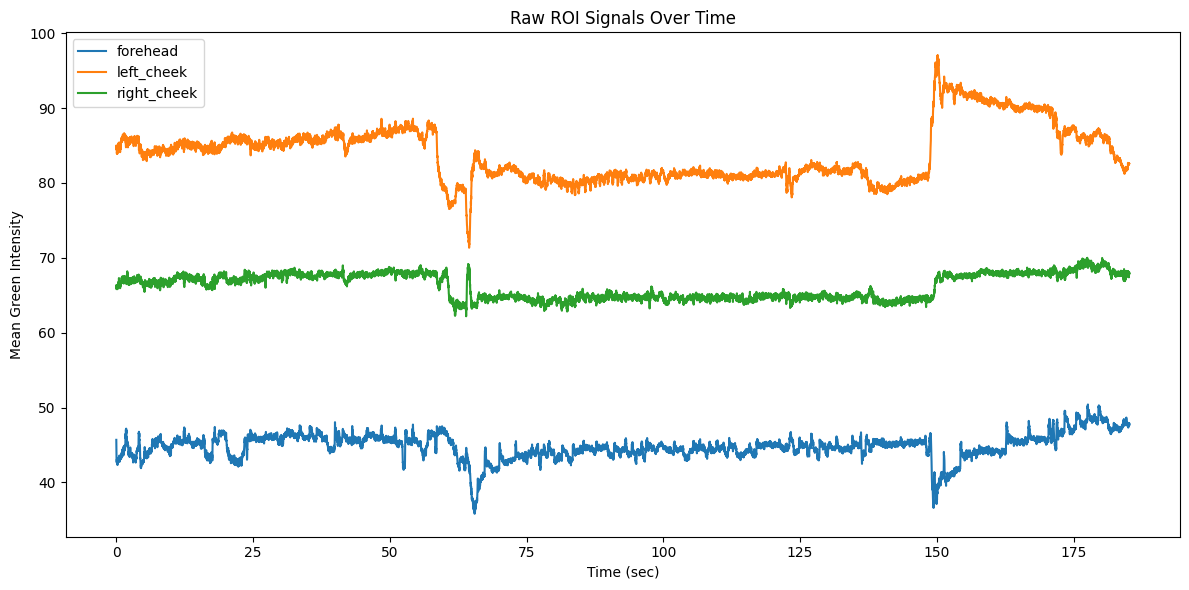

In [23]:
# === EDA - Visualize raw signals ===

#Time axis in seconds
time_sec = frame_indices/fps

plt.figure(figsize=(12,6))
for name in roi_signal:
    plt.plot(time_sec, roi_signal[name], label =name)
plt.xlabel("Time (sec)")
plt.ylabel("Mean Green Intensity")
plt.title("Raw ROI Signals Over Time")
plt.legend()
plt.tight_layout()
plt.show() 

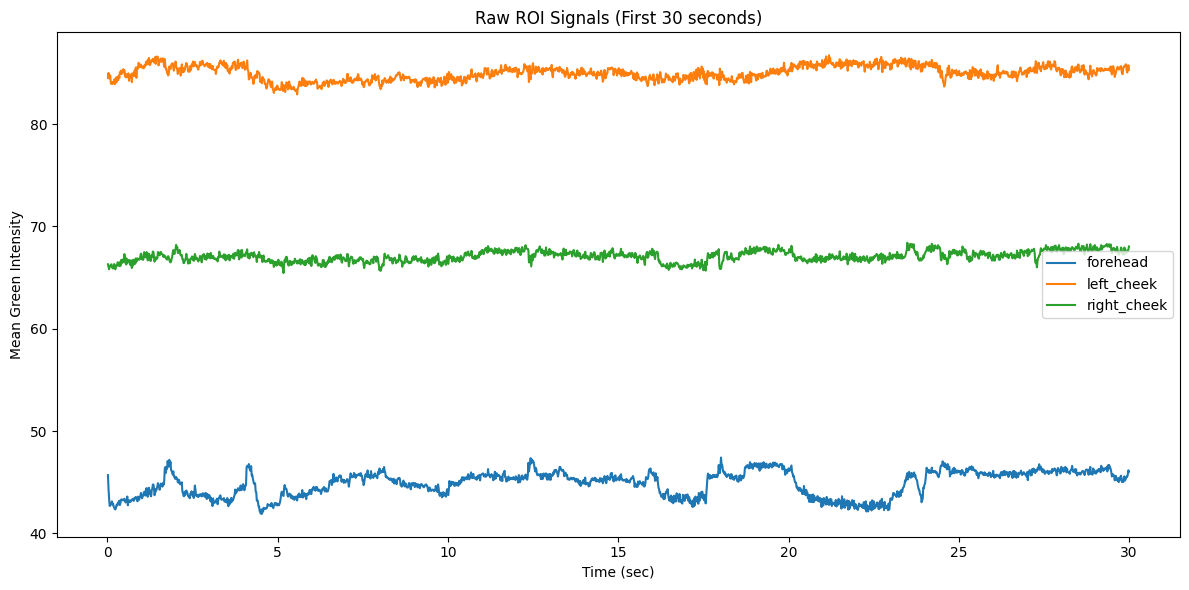

In [24]:
# Zoom into first 30 seconds
max_t = 30
mask_30 = time_sec<=max_t

plt.figure(figsize=(12,6))
for name in roi_signal:
    plt.plot(time_sec[mask_30], roi_signal[name][mask_30], label =name) 
plt.xlabel("Time (sec)")
plt.ylabel("Mean Green Intensity")  

plt.title("Raw ROI Signals (First 30 seconds)")
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# === Preprocess signal (detrend + bandpas filter) ===

from scipy import signal
import numpy as np

def preprocess_rppg(raw_signal, fps, low_hz=0.7, high_hz=4.0):
    """
    Detrend + bandpass filter the rPPG signal.
    - raw_signal: 1D numpy array (may contain NaNs)
    - fps: frames per second of the video
    """
    # ----- safety for fps -----
    if fps is None or fps <= 0:
        # fallback if CAP_PROP_FPS failed → assume typical webcam/video FPS
        fps = 30.0  

    sig = raw_signal.astype(np.float32).copy()
    n = len(sig)
    t = np.arange(n)

    # Handle NaNs by interpolation
    valid = ~np.isnan(sig)
    if valid.sum() < 10:
        # Not enough valid samples
        return np.full_like(sig, np.nan, dtype=np.float32)

    sig[~valid] = np.interp(t[~valid], t[valid], sig[valid])

    # Detrend
    sig_detrended = signal.detrend(sig)

    # ----- bandpass filter design -----
    nyquist = 0.5 * fps       # in Hz
    # Make sure high_hz < nyquist
    if high_hz >= nyquist:
        high_hz = 0.9 * nyquist   # clamp to just below Nyquist

    low = low_hz / nyquist
    high = high_hz / nyquist

    # Final safety: low must be < high and both between 0 and 1
    low = max(low, 1e-4)
    high = min(high, 0.999)

    if not (0 < low < high < 1):
        raise ValueError(
            f"Invalid band [{low_hz}, {high_hz}] Hz for fps={fps}. "
            f"Got normalized low={low:.3f}, high={high:.3f}"
        )

    b, a = signal.butter(3, [low, high], btype="bandpass")
    sig_filtered = signal.filtfilt(b, a, sig_detrended)

    return sig_filtered


In [32]:

plt.figure(figsize=(8,6))
plt.plot(time_sec, roi_signals[roi_name], label="Raw Signal", alpha=0.5)
plt.plot(time_sec, filtered_signals[roi_name], label="Filtered Signal", color='red')
plt.xlabel("Time (sec)")
plt.ylabel("Mean Green Intensity")
plt.title(f"Raw vs Filtered Signal - {roi_name}")
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'roi_signals' is not defined

<Figure size 800x600 with 0 Axes>